# Studio del rapporto E/charge al variare dell'energia

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
import os

In [2]:
os.makedirs("/tmp/linearità/", exist_ok=True)
output = open("/tmp/linearità/results.log", "w")
output.write("# f = a + b*x + c*x^2\n#ch\t\ta\t\tb\t\tc\t\tchi2\n")

41

In [3]:
nominal = {"cs":[662], "na":[551,1275], "co":[1173,1332], "ba":[302,356]}

cs = pd.read_table('CalibK_Cs.dat', header=None, sep=" ", comment='#')
na = pd.read_table('CalibK_Na.dat', header=None, sep=" ", comment='#')
co = pd.read_table('CalibK_Co.dat', header=None, sep=" ", comment='#')
ba =  pd.read_table('CalibK_Ba.dat', header=None, sep=" ", comment='#', usecols=[2,3])

In [4]:
def func(x, a, b, c):
    return a + x*b + x*x*c #+ x*x*x*d

fitfunc=Model(func)
params = fitfunc.make_params(a=0, b=1, c=0, d=0)

In [5]:
x=[]
for source in ["cs", "na", "co", "ba"]:
    for value in nominal[source]:
        x.append(value)
x=np.sort(x)

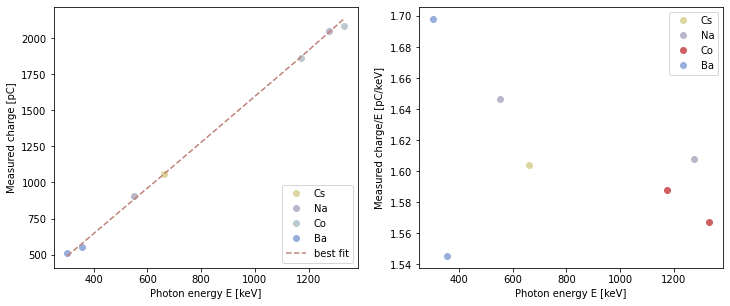

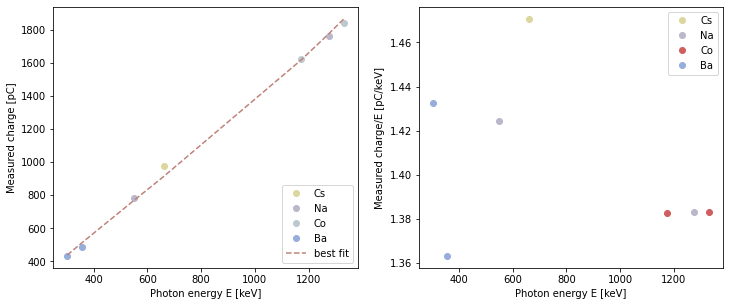

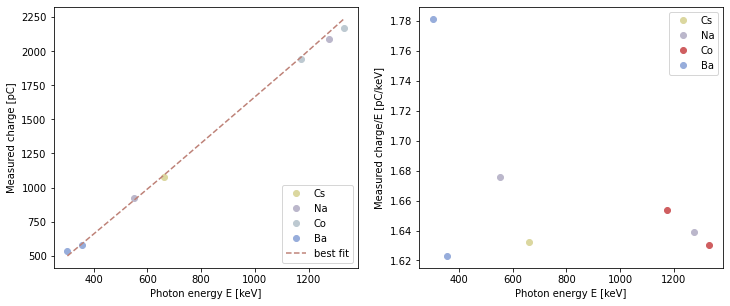

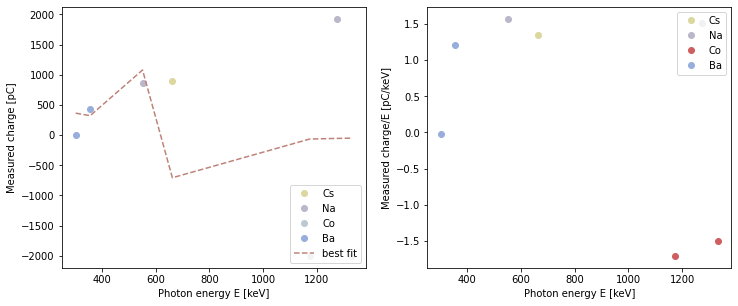

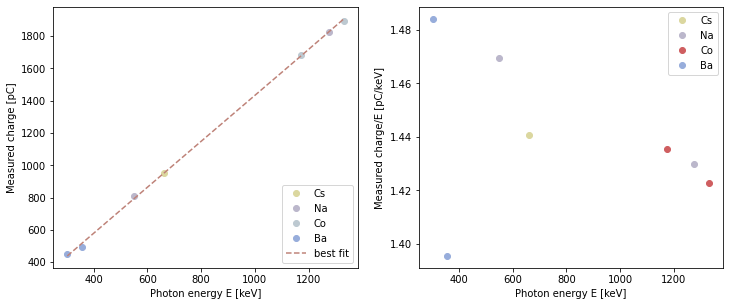

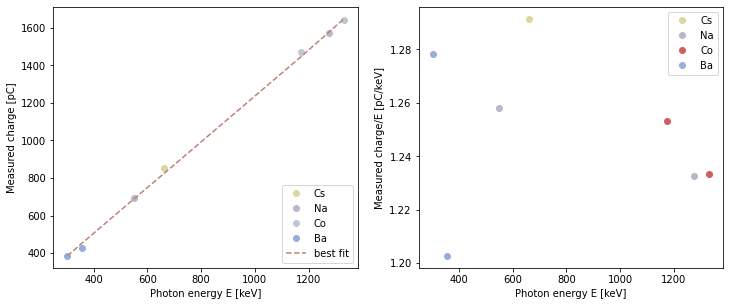

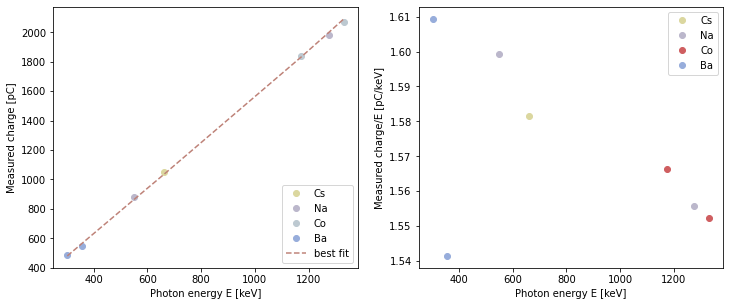

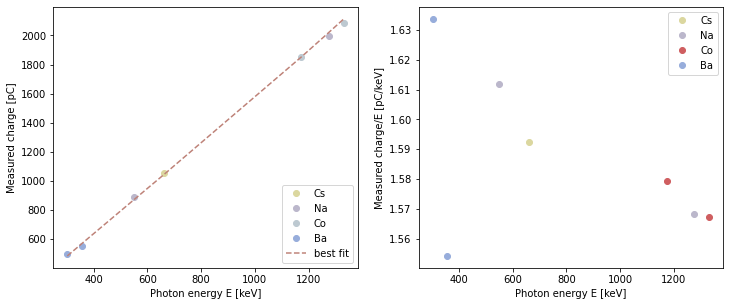

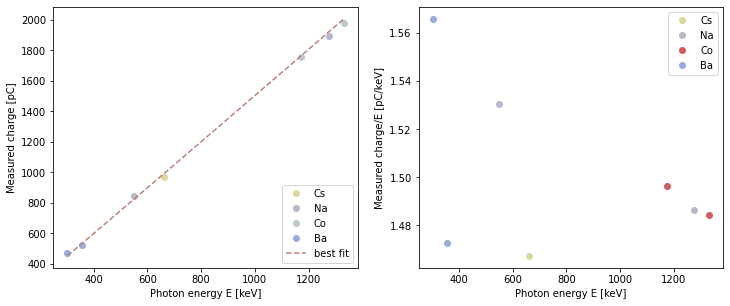

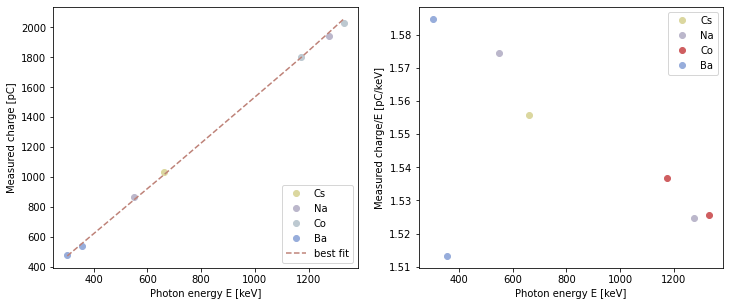

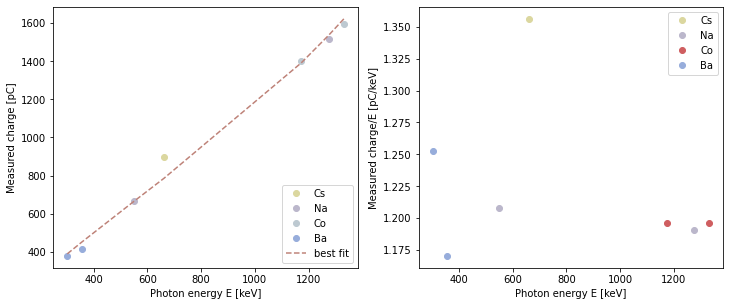

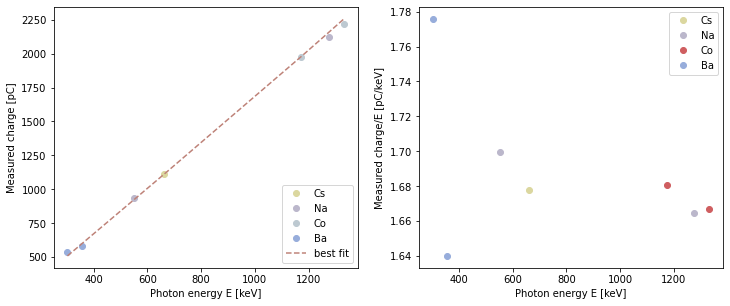

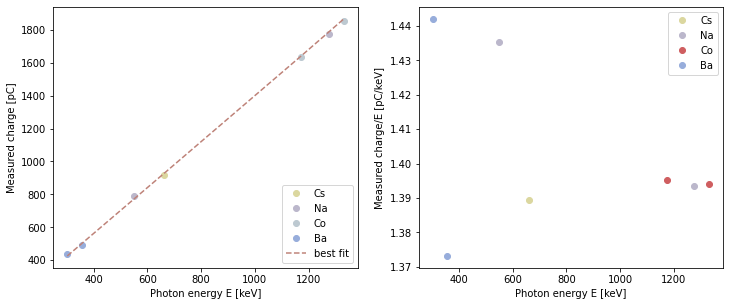

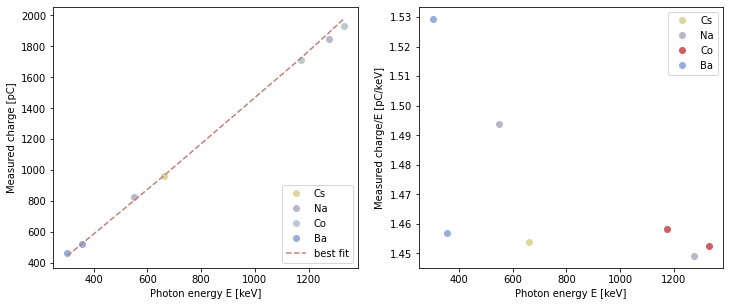

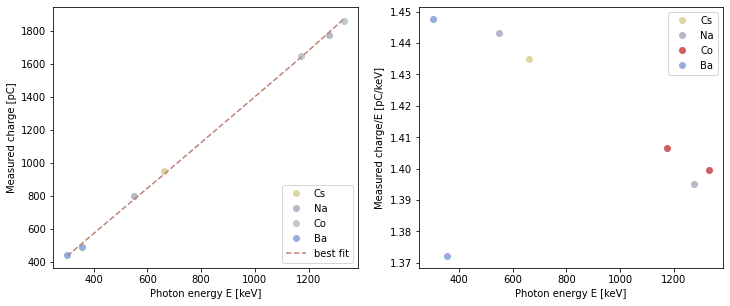

Plots saved in /tmp/linearità/ . Fit results saved in /tmp/linerità/results.log


In [6]:
for ch in range(0,15):
    y=np.array([np.array(cs.loc[ch])[0], np.array(na.loc[ch])[0], np.array(na.loc[ch])[1], np.array(co.loc[ch])[0], np.array(co.loc[ch])[1], np.array(ba.loc[ch])[0], np.array(ba.loc[ch])[1]])
    
    results = fitfunc.fit(y, params, x=x)
    
    output.write(str(ch)+"\t"+str(results.best_values["a"])+"\t"+str(results.best_values["b"])+"\t"+str(results.best_values["c"])+"\t"+str(results.chisqr)+"\n")
    
    fig, ax = plt.subplots(1,2, figsize=[12, 4.8])
    
    ax[0].set_xlabel('Photon energy E [keV]')
    ax[0].set_ylabel('Measured charge [pC]')

    ax[0].plot(nominal['cs'], nominal['cs']/np.array(cs.loc[ch]), ".", color=[219/255, 215/255, 159/255], markersize=12, label='Cs')
    ax[0].plot(nominal['na'], nominal['na']/np.array(na.loc[ch]), ".", color=[187/255, 183/255, 203/255], markersize=12, label='Na')
    ax[0].plot(nominal['co'], nominal['co']/np.array(co.loc[ch]), ".", color=[189/255, 201/255, 209/255], markersize=12, label='Co')
    ax[0].plot(nominal['ba'], nominal['ba']/np.array(ba.loc[ch]), ".", color=[151/255,173/255,219/255], markersize=12, label='Ba')
    
    ax[0].plot(x, x/results.best_fit, "--", label="best fit", color=[190/255, 130/255, 120/255] )
    
    legend0 = ax[0].legend(loc='lower right')
    
    ax[1].set_xlabel('Photon energy E [keV]')
    ax[1].set_ylabel('Measured charge/E [pC/keV]')
    
    ax[1].plot(nominal['cs'], 1/np.array(cs.loc[ch]), ".", color=[219/255, 215/255, 159/255], markersize=12, label='Cs')
    ax[1].plot(nominal['na'], 1/np.array(na.loc[ch]), ".", color=[187/255, 183/255, 203/255], markersize=12, label='Na')
    ax[1].plot(nominal['co'], 1/np.array(co.loc[ch]), ".", color=[0.812,0.369,0.377], markersize=12, label='Co')
    ax[1].plot(nominal['ba'], 1/np.array(ba.loc[ch]), ".", color=[151/255,173/255,219/255], markersize=12, label='Ba')
    
    legend1 = ax[1].legend(loc='upper right')
    
    plt.savefig("/tmp/linearità/ch"+str(ch)+".pdf", format="pdf")
        
    plt.show()
    
print("Plots saved in /tmp/linearità/ . Fit results saved in /tmp/linerità/results.log")
output.close()

# Studio della linearità dei singoli canali

In [ ]:
def line_func(x, m, q):
    return m*x + q

In [ ]:
nominal={"Cs":[662], "Na":[511, 1275], "Co":[1173,1332], "Ba":[81, 160, 276, 302, 356]} # keV

In [ ]:
def myParser(filename):
    
    ch=[]
    xs, ys, errs=[],[],[]
    start_saving=False
    
    with open(filename, "r") as file:
        for line in file:
            words=line.split()
            if words[0]=="channel":
                ch.append(int(words[1]))
                if start_saving:
                    xs.append(x)
                    ys.append(y)
                    errs.append(err)
                start_saving=True
                x, y, err=[],[],[]
                
            else:
            
                source=words.pop(0) # pops name of source
                x.extend(nominal[source]) # saves nominal values for the given source
                y.extend([int(value) for value in words[0::2]]) # peeaks are odd values (1, 3, 5, ...)
                err.extend([int(error) for error in words[1::2]]) # errors are even
        
        xs.append(x)
        ys.append(y)
        errs.append(err)  
        
    return ch, np.array(xs), np.array(ys), np.array(errs)

In [ ]:
ch, xdata, ydata, yerr = myParser("prova.txt")

os.makedirs("/tmp/linearity_plots/", exist_ok=True)

output=open("linearità.txt", "w")
output.write("# channel\tslope\t\tsigma_slope\tintercept\tsigma_interc\n")
            
for channel in ch:  
    
    popt, pcov = curve_fit(line_func, xdata[channel], ydata[channel], sigma=yerr[channel], absolute_sigma=True)

    perr=np.sqrt(np.diag(pcov))
    
    popt=np.around(popt, 4)
    perr=np.around(perr,4)
    
    tmp=(str(popt[0]),str(perr[0]), str(popt[0]), str(perr[1]))
    output.write(str(channel)+"\t\t"+"\t\t".join(tmp)+"\n")

    plt.figure()
    
    plt.errorbar(xdata[channel], ydata[channel], yerr=yerr[channel], fmt="b.", elinewidth=2, capsize=3)
    plt.plot(xdata[channel], line_func(xdata[channel], *popt), 'c-')
    
    plt.savefig("/tmp/linearity_plots/channel" + str(channel) + ".pdf", format="pdf")

output.close()

print("Plots saved in /tmp/linearity_plots.")